In [1]:
# imports
import h2o 
import numpy as np
import pandas as pd
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

In [2]:
# display matplotlib graphics in notebook
%matplotlib inline

In [3]:
# start and connect to h2o server
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-macosx) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-macosx) (build 25.121-b15, mixed mode)
  Starting server from /Users/bear/anaconda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmpw_a3y2kf
  JVM stdout: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmpw_a3y2kf/h2o_bear_started_from_python.out
  JVM stderr: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmpw_a3y2kf/h2o_bear_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.1
H2O cluster version age:,25 days
H2O cluster name:,H2O_from_python_bear_d9y5oa
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [4]:
# load clean data
path = 'data/loan.csv'

In [5]:
# define input variable measurement levels 
# strings automatically parsed as enums (nominal)
# numbers automatically parsed as numeric
col_types = {'bad_loan': 'enum'}

In [6]:
frame = h2o.import_file(path=path, col_types=col_types) # import from url

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
frame.describe() # summarize data

Rows:163987
Cols:15




,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,enum,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,,0.0,
mean,13074.169141456336,,13.715904065566173,5.68435293299533,,71915.67051974901,,,15.881530121290117,0.2273570060625282,54.07917280242258,24.579733834274638,,14.854273655448353,
maxs,35000.0,,26.06,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,,65.0,
sigma,7993.556188734649,,4.391939870545795,3.6106637311002365,,59070.915654918244,,,7.587668224192549,0.6941679229284182,25.285366766770505,11.685190365910659,,6.947732922546696,
zeros,0,,0,14248,,0,,,270,139459,1562,0,,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified


In [8]:
# split into 40% training, 30% validation, and 30% test
train, valid, test = frame.split_frame([0.4, 0.3])

In [9]:
# assign target and inputs
y = 'bad_loan'
X = [name for name in frame.columns if name != y]
print(y)
print(X)

bad_loan
['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'revol_util', 'total_acc', 'longest_credit_length', 'verification_status']


In [10]:
# determine column types
reals, enums = [], []
for key, val in frame.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        else: 
            reals.append(key)

print(enums)
print(reals)

['term', 'home_ownership', 'purpose', 'addr_state', 'verification_status']
['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'revol_util', 'total_acc', 'longest_credit_length']


In [11]:
# impute missing values
_ = frame[reals].impute(method='mean')

In [12]:
# set target to factor - for binary classification
# just to be safe ...
train[y] = train[y].asfactor()
valid[y] = valid[y].asfactor()
test[y] = test[y].asfactor()

In [13]:
# neural network

# initialize nn model
nn_model = H2ODeepLearningEstimator(
    epochs=50,                    # read over the data 50 times, but in mini-batches
    hidden=[100],                 # 100 hidden units in 1 hidden layer
    input_dropout_ratio=0.2,      # randomly drop 20% of inputs for each iteration, helps w/ generalization
    hidden_dropout_ratios=[0.05], # randomly set 5% of hidden weights to 0 each iteration, helps w/ generalization
    activation='TanhWithDropout', # bounded activation function that allows for dropout, tanh
    l1=0.001,                     # L1 penalty can help generalization   
    l2=0.01,                      # L2 penalty can increase stability in presence of highly correlated inputs
    adaptive_rate=True,           # adjust magnitude of weight updates automatically (+stability, +accuracy)
    stopping_rounds=5,            # stop after validation error does not decrease for 5 iterations
    score_each_iteration=True,    # score validation error on every iteration
    model_id='nn_model')          # for easy lookup in flow

# train nn model
nn_model.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid)

# print model information
nn_model

# view detailed results at http://localhost:54321/flow/index.html

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  nn_model


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.14012752126328837
RMSE: 0.3743361073464439
LogLoss: 0.4443499533129185
Mean Per-Class Error: 0.35657985163704065
AUC: 0.6915638683615544
pr_auc: 0.3288191580005072
Gini: 0.38312773672310874
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19205222874853198: 


,0,1,Error,Rate
0,5439.0,2757.0,0.3364,(2757.0/8196.0)
1,704.0,1158.0,0.3781,(704.0/1862.0)
Total,6143.0,3915.0,0.3441,(3461.0/10058.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1920522,0.4009001,241.0
max f2,0.1022221,0.5587889,340.0
max f0point5,0.2764877,0.3648265,166.0
max accuracy,0.5601438,0.8152714,16.0
max precision,0.6143296,0.6363636,4.0
max recall,0.0491335,1.0,397.0
max specificity,0.6404717,0.9998780,0.0
max absolute_mcc,0.2416466,0.2318230,194.0
max min_per_class_accuracy,0.1852852,0.6385607,248.0
max mean_per_class_accuracy,0.1767027,0.6434201,257.0


Gains/Lift Table: Avg response rate: 18.51 %, avg score: 19.14 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100418,0.5282891,2.5671534,2.5671534,0.4752475,0.5664361,0.4752475,0.5664361,0.0257787,0.0257787,156.7153386,156.7153386
,2,0.0200835,0.4910055,2.4067063,2.4869298,0.4455446,0.5071435,0.4603960,0.5367898,0.0241676,0.0499463,140.6706299,148.6929842
,3,0.0300259,0.4660290,2.1606874,2.3789026,0.4,0.4780564,0.4403974,0.5173416,0.0214823,0.0714286,116.0687433,137.8902554
,4,0.0400676,0.4445939,2.2997416,2.3590632,0.4257426,0.4538818,0.4367246,0.5014373,0.0230934,0.0945220,129.9741575,135.9063202
,5,0.0500099,0.4264832,2.5388077,2.3947977,0.47,0.4359910,0.4433400,0.4884261,0.0252417,0.1197637,153.8807734,139.4797701
,6,0.1000199,0.3559731,2.0618886,2.2283432,0.3817097,0.3896852,0.4125249,0.4390557,0.1031149,0.2228786,106.1888604,122.8343153
,7,0.1500298,0.3097427,1.5786335,2.0117733,0.2922465,0.3320255,0.3724321,0.4033789,0.0789474,0.3018260,57.8633462,101.1773256
,8,0.2000398,0.2744718,1.7182405,1.9383901,0.3180915,0.2918115,0.3588469,0.3754871,0.0859291,0.3877551,71.8240503,93.8390068
,9,0.3000597,0.2226946,1.2994194,1.7253998,0.2405567,0.2465595,0.3194168,0.3325112,0.1299678,0.5177229,29.9419381,72.5399839
,10,0.3999801,0.1883361,1.1233425,1.5749977,0.2079602,0.2045363,0.2915735,0.3005414,0.1122449,0.6299678,12.3342471,57.4997737




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.13897766905487463
RMSE: 0.37279708831330033
LogLoss: 0.4413991844691089
Mean Per-Class Error: 0.35983832063361787
AUC: 0.6906684424910284
pr_auc: 0.32383478570708496
Gini: 0.38133688498205687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1974062202858475: 


,0,1,Error,Rate
0,27617.0,12638.0,0.3139,(12638.0/40255.0)
1,3672.0,5313.0,0.4087,(3672.0/8985.0)
Total,31289.0,17951.0,0.3312,(16310.0/49240.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1974062,0.3944906,235.0
max f2,0.1137712,0.5579900,327.0
max f0point5,0.2646972,0.3525951,179.0
max accuracy,0.5346475,0.8179529,26.0
max precision,0.6573121,1.0,0.0
max recall,0.0420548,1.0,399.0
max specificity,0.6573121,1.0,0.0
max absolute_mcc,0.2067180,0.2228142,226.0
max min_per_class_accuracy,0.1822872,0.6386039,250.0
max mean_per_class_accuracy,0.1868849,0.6401617,245.0


Gains/Lift Table: Avg response rate: 18.25 %, avg score: 18.94 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100122,0.5279233,2.8234933,2.8234933,0.5152130,0.5629432,0.5152130,0.5629432,0.0282693,0.0282693,182.3493291,182.3493291
,2,0.0200041,0.4928367,2.3057128,2.5648659,0.4207317,0.5086217,0.4680203,0.5358100,0.0230384,0.0513077,130.5712773,156.4865865
,3,0.0300162,0.4682940,2.3121520,2.4805709,0.4219067,0.4803190,0.4526387,0.5173005,0.0231497,0.0744574,131.2151986,148.0570911
,4,0.0400081,0.4445787,2.2166031,2.4146460,0.4044715,0.4560534,0.4406091,0.5020043,0.0221480,0.0966055,121.6603101,141.4645955
,5,0.05,0.4254451,2.1163547,2.3550362,0.3861789,0.4347478,0.4297319,0.4885639,0.0211464,0.1177518,111.6354719,135.5036171
,6,0.1,0.3539732,1.9766277,2.1658319,0.3606824,0.3866333,0.3952071,0.4375986,0.0988314,0.2165832,97.6627713,116.5831942
,7,0.15,0.3056372,1.6605454,1.9974031,0.3030057,0.3279686,0.3644733,0.4010553,0.0830273,0.2996105,66.0545353,99.7403079
,8,0.2,0.2706790,1.5648303,1.8892599,0.2855402,0.2874530,0.3447400,0.3726547,0.0782415,0.3778520,56.4830273,88.9259878
,9,0.3,0.2208702,1.3756260,1.7180486,0.2510154,0.2442839,0.3134985,0.3298644,0.1375626,0.5154146,37.5626043,71.8048600
,10,0.4,0.1854103,1.1329994,1.5717863,0.2067425,0.2022861,0.2868095,0.2979698,0.1132999,0.6287145,13.2999444,57.1786311



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-01-22 22:06:37,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2019-01-22 22:06:40,3.425 sec,61287 obs/sec,1.5207721,1,99898.0,0.3763558,0.4485231,0.0610579,0.6865071,0.3172083,2.6741181,0.3517598,0.3747239,0.4456429,0.0587156,0.6844977,0.3105912,2.4010809,0.3523152
,2019-01-22 22:06:42,5.076 sec,67805 obs/sec,3.0409049,2,199754.0,0.3756996,0.4471919,0.0643289,0.6904794,0.3253858,2.5136710,0.3578246,0.3736552,0.4434750,0.0640770,0.6902084,0.3223763,2.6456354,0.3314582
,2019-01-22 22:06:43,6.674 sec,70761 obs/sec,4.5652545,3,299887.0,0.3758601,0.4469642,0.0635294,0.6935855,0.3279707,2.7276005,0.3468880,0.3745827,0.4446944,0.0594248,0.6907063,0.3198812,2.6011710,0.3358245
,2019-01-22 22:06:46,10.050 sec,57386 obs/sec,6.0838497,4,399642.0,0.3750631,0.4457444,0.0674966,0.6933985,0.3257405,2.4601887,0.3481806,0.3736062,0.4432613,0.0643221,0.6903752,0.3185696,2.5233582,0.3434809
,2019-01-22 22:06:48,11.742 sec,60042 obs/sec,7.6075142,5,499730.0,0.3749771,0.4450299,0.0679246,0.6933639,0.3254129,2.5136710,0.3515609,0.3735537,0.4426301,0.0645849,0.6902950,0.3202217,2.5678226,0.3479082
,2019-01-22 22:06:50,13.418 sec,61783 obs/sec,9.1299457,6,599737.0,0.3793766,0.4577637,0.0459246,0.6930467,0.3265816,2.5136710,0.3281965,0.3777288,0.4549449,0.0435586,0.6905258,0.3190850,2.6567516,0.3372055
,2019-01-22 22:06:52,15.069 sec,63289 obs/sec,10.6501545,7,699598.0,0.3802903,0.4612184,0.0413235,0.6895221,0.3254187,2.5671534,0.4082323,0.3781773,0.4571188,0.0412860,0.6903672,0.3217577,2.7456805,0.3325142
,2019-01-22 22:06:53,16.646 sec,64747 obs/sec,12.1739104,8,799692.0,0.3765912,0.4498010,0.0598829,0.6913469,0.3277308,2.7810828,0.3712468,0.3748770,0.4466274,0.0579461,0.6907285,0.3237248,2.7123321,0.3479285
,2019-01-22 22:06:55,18.213 sec,65944 obs/sec,13.6960831,9,899682.0,0.3743361,0.4443500,0.0711083,0.6915639,0.3288192,2.5671534,0.3441042,0.3727971,0.4413992,0.0683706,0.6906684,0.3238348,2.8234933,0.3312348


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
purpose.small_business,1.0,1.0,0.0609041
addr_state.CO,0.5995688,0.5995688,0.0365162
annual_inc,0.5280226,0.5280226,0.0321587
int_rate,0.5251197,0.5251197,0.0319819
addr_state.WV,0.4575950,0.4575950,0.0278694
---,---,---,---
addr_state.missing(NA),0.0,0.0,0.0
purpose.missing(NA),0.0,0.0,0.0
home_ownership.missing(NA),0.0,0.0,0.0
term.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [14]:
# measure nn AUC
print(nn_model.auc(train=True))
print(nn_model.auc(valid=True))
print(nn_model.model_performance(test_data=test).auc())

0.6915638683615544
0.6906684424910284
0.6956753398991676


In [15]:
# NN with random hyperparameter search
# train many different NN models with random hyperparameters
# and select best model based on validation error

# define random grid search parameters
hyper_parameters = {'hidden':[[170, 320], [80, 190], [320, 160, 80], [100], [50, 50, 50, 50]],
                    'l1':[s/1e4 for s in range(0, 1000, 100)],
                    'l2':[s/1e5 for s in range(0, 1000, 100)],
                    'input_dropout_ratio':[s/1e2 for s in range(0, 20, 2)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':20,
                   'max_runtime_secs':600}

# initialize grid search
gsearch = H2OGridSearch(H2ODeepLearningEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch.train(x=X,
              y=y,
              training_frame=train,
              validation_frame=valid)

# view detailed results at http://ip:port/flow/index.html

deeplearning Grid Build progress: |███████████████████████████████████████| 100%


In [16]:
# show grid search results
gsearch.show()

# select best model
nn_model2 = gsearch.get_grid()[0]

# print model information
nn_model2

                hidden input_dropout_ratio    l1     l2  \
0                [100]                 0.0   0.0  0.003   
1                [100]                0.16   0.0  0.006   
2           [170, 320]                 0.0   0.0  0.009   
3           [170, 320]                0.06  0.07  0.006   
4            [80, 190]                0.12  0.05  0.002   
5     [50, 50, 50, 50]                0.18  0.08  0.009   
6           [170, 320]                 0.0  0.01  0.009   
7                [100]                 0.1  0.04  0.008   
8     [50, 50, 50, 50]                0.12  0.03  0.008   
9            [80, 190]                 0.0  0.02  0.006   
10      [320, 160, 80]                0.18  0.08    0.0   
11    [50, 50, 50, 50]                0.04  0.07    0.0   
12      [320, 160, 80]                0.02  0.07  0.004   
13      [320, 160, 80]                0.08  0.02  0.003   
14          [170, 320]                0.16  0.04  0.009   
15               [100]                0.06  0.06  0.007 

,0,1,Error,Rate
0,5653.0,2578.0,0.3132,(2578.0/8231.0)
1,704.0,1159.0,0.3779,(704.0/1863.0)
Total,6357.0,3737.0,0.3251,(3282.0/10094.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1930912,0.4139286,232.0
max f2,0.0949289,0.5759181,318.0
max f0point5,0.2957195,0.3838362,158.0
max accuracy,0.5573295,0.8172181,29.0
max precision,0.7209391,1.0,0.0
max recall,0.0079578,1.0,397.0
max specificity,0.7209391,1.0,0.0
max absolute_mcc,0.2307897,0.2508450,202.0
max min_per_class_accuracy,0.1789096,0.6539910,243.0
max mean_per_class_accuracy,0.1445658,0.6589279,272.0


Gains/Lift Table: Avg response rate: 18.46 %, avg score: 17.98 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100059,0.5604169,3.0577637,3.0577637,0.5643564,0.6072087,0.5643564,0.6072087,0.0305958,0.0305958,205.7763747,205.7763747
,2,0.0200119,0.5234729,2.7358939,2.8968288,0.5049505,0.5406898,0.5346535,0.5739492,0.0273752,0.0579710,173.5893879,189.6828813
,3,0.0300178,0.4885754,2.4140240,2.7358939,0.4455446,0.5057157,0.5049505,0.5512047,0.0241546,0.0821256,141.4024011,173.5893879
,4,0.0400238,0.4641976,1.8775742,2.5213140,0.3465347,0.4762840,0.4653465,0.5324745,0.0187869,0.1009125,87.7574231,152.1313967
,5,0.0500297,0.4449217,2.2530891,2.4676690,0.4158416,0.4553938,0.4554455,0.5170584,0.0225443,0.1234568,125.3089077,146.7668989
,6,0.1000594,0.3756950,1.9741352,2.2209021,0.3643564,0.4077109,0.4099010,0.4623846,0.0987654,0.2222222,97.4135191,122.0902090
,7,0.1499901,0.3252005,1.9350510,2.1257443,0.3571429,0.3499487,0.3923382,0.4249555,0.0966184,0.3188406,93.5050993,112.5744261
,8,0.2000198,0.2843098,1.7810133,2.0395188,0.3287129,0.3037995,0.3764240,0.3946515,0.0891036,0.4079442,78.1013270,103.9518828
,9,0.2999802,0.2259268,1.2941253,1.7911364,0.2388503,0.2532546,0.3305812,0.3475348,0.1293612,0.5373054,29.4125283,79.1136368
,10,0.4000396,0.1798498,1.1265445,1.6249061,0.2079208,0.2015194,0.2999009,0.3110128,0.1127214,0.6500268,12.6544539,62.4906119




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.13879047534556194
RMSE: 0.3725459372286348
LogLoss: 0.44092351643259303
Mean Per-Class Error: 0.35729763796421077
AUC: 0.6967998458906275
pr_auc: 0.33044848884930395
Gini: 0.393599691781255
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1811819503331: 


,0,1,Error,Rate
0,26221.0,14034.0,0.3486,(14034.0/40255.0)
1,3289.0,5696.0,0.3661,(3289.0/8985.0)
Total,29510.0,19730.0,0.3518,(17323.0/49240.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1811820,0.3967264,244.0
max f2,0.0848574,0.5602304,327.0
max f0point5,0.3143748,0.3642425,153.0
max accuracy,0.6323327,0.8179732,21.0
max precision,0.8665182,1.0,0.0
max recall,0.0042249,1.0,398.0
max specificity,0.8665182,1.0,0.0
max absolute_mcc,0.2264356,0.2310770,210.0
max min_per_class_accuracy,0.1776821,0.6416346,247.0
max mean_per_class_accuracy,0.1792132,0.6427024,246.0


Gains/Lift Table: Avg response rate: 18.25 %, avg score: 18.04 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100122,0.5724630,2.7456805,2.7456805,0.5010142,0.6229843,0.5010142,0.6229843,0.0274903,0.0274903,174.5680484,174.5680484
,2,0.0200041,0.5273744,2.5284870,2.6371940,0.4613821,0.5469630,0.4812183,0.5850123,0.0252643,0.0527546,152.8486954,163.7193970
,3,0.0300162,0.4972833,2.3788487,2.5510206,0.4340771,0.5126340,0.4654939,0.5608698,0.0238175,0.0765721,137.8848678,155.1020608
,4,0.0400081,0.4731430,2.1831870,2.4591556,0.3983740,0.4851073,0.4487310,0.5419484,0.0218141,0.0983862,118.3186974,145.9155558
,5,0.05,0.4521931,2.1609096,2.3995548,0.3943089,0.4623610,0.4378554,0.5260439,0.0215915,0.1199777,116.0909556,139.9554814
,6,0.1,0.3768911,1.9855314,2.1925431,0.3623071,0.4117142,0.4000812,0.4688790,0.0992766,0.2192543,98.5531441,119.2543127
,7,0.15,0.3235952,1.8408459,2.0753107,0.3359058,0.3488400,0.3786894,0.4288660,0.0920423,0.3112966,84.0845854,107.5310703
,8,0.2,0.2853326,1.5047301,1.9326656,0.2745735,0.3038265,0.3526604,0.3976061,0.0752365,0.3865331,50.4730106,93.2665554
,9,0.3,0.2246803,1.3689482,1.7447598,0.2497969,0.2527313,0.3183726,0.3493145,0.1368948,0.5234279,36.8948247,74.4759785
,10,0.4,0.1808495,1.0951586,1.5823595,0.1998375,0.2017972,0.2887388,0.3124352,0.1095159,0.6329438,9.5158598,58.2359488



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-01-22 22:07:46,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2019-01-22 22:07:47,48.439 sec,72987 obs/sec,1.0,1,65689.0,0.3805142,0.4539653,0.0379383,0.6921919,0.3235207,2.8431838,0.3452546,0.3810818,0.4565396,0.0265030,0.6818557,0.3159448,2.5900549,0.3565800
,2019-01-22 22:07:51,52.769 sec,131430 obs/sec,10.0,10,656890.0,0.3706103,0.4349174,0.0873671,0.7145816,0.3537231,3.0577637,0.3251436,0.3725459,0.4409235,0.0696254,0.6967998,0.3304485,2.7456805,0.3518075


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
addr_state.MO,1.0,1.0,0.0151903
purpose.small_business,0.9904335,0.9904335,0.0150450
addr_state.TN,0.9665326,0.9665326,0.0146819
purpose.renewable_energy,0.9472735,0.9472735,0.0143894
addr_state.DC,0.9444687,0.9444687,0.0143468
---,---,---,---
addr_state.missing(NA),0.0,0.0,0.0
purpose.missing(NA),0.0,0.0,0.0
home_ownership.missing(NA),0.0,0.0,0.0
term.missing(NA),0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [17]:
# measure nn AUC
print(nn_model2.auc(train=True))
print(nn_model2.auc(valid=True))
print(nn_model2.model_performance(test_data=test).auc())

0.7145815998888247
0.6967998458906275
0.7041325607237255


## Partial dependence plots 

The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model. A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonous or more complex.

[https://christophm.github.io/interpretable-ml-book/pdp.html](https://christophm.github.io/interpretable-ml-book/pdp.html)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


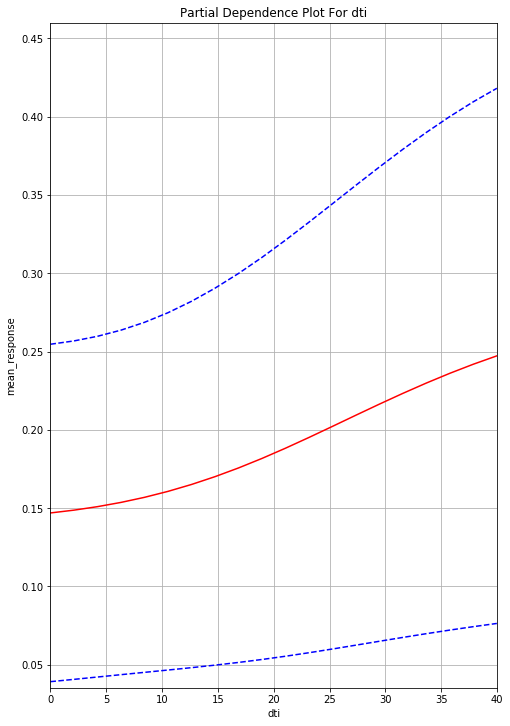

In [18]:
# partial dependence plots are a powerful machine learning interpretation tool
# to calculate partial dependence across the domain a variable
# hold column of interest at constant value
# find the mean prediction of the model with this column constant
# repeat for multiple values of the variable of interest
# h2o has a built-in function for partial dependence as well
par_dep_dti1 = nn_model2.partial_plot(data=train, cols=['dti'], server=True, plot=True)

In [19]:
# shutdown h2o
# be careful ... this can erase your work
h2o.cluster().shutdown()

H2O session _sid_b0d1 closed.
